In [1]:
import TrainSetGen as trainingSG
import TestingSetGen as testingSG

[train_label, train_coords_A, train_coords_B] = trainingSG.getPoints()
[test_label, test_coords_A, test_coords_B] = testingSG.getPoints()

# import numpy as np
# train_data_coords, train_coords_A, train_coords_B
# test_data_coords, test_coords_A, test_coords_B
# np.shape(train_coords_A)[0]


In [2]:
import Common as cm

[train_w, train_doppler] = cm.getWAndDoppler(train_coords_A, train_coords_B)
[test_w, test_doppler] = cm.getWAndDoppler(test_coords_A, test_coords_B)

# train_w, train_doppler

In [3]:
import numpy as np
import Config as cf

vertex1 = np.array([0, 0])
vertex2 = np.array([200, 0])
vertex3 = np.array([100, 100])
vertex4 = np.array([300, 150])

vertices_position = np.concatenate((vertex1, vertex2, vertex3, vertex4))
        
train_position = np.full((cf.train_points_num, len(vertices_position)), vertices_position)
test_position = np.full((cf.test_points_num, len(vertices_position)), vertices_position)


In [4]:
# test_w, test_doppler, test_position
# np.shape(test_w), np.shape(test_doppler), np.shape(test_position)s

In [5]:
# import torch.nn as nn

# def pointInTriangle(pt, v1, v2, v3):
#     # Barycentric coordinates method
#     def sign(p1, p2, p3):
#         return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

#     b1 = sign(pt, v1, v2) < 0.0
#     b2 = sign(pt, v2, v3) < 0.0
#     b3 = sign(pt, v3, v1) < 0.0

#     return ((b1 == b2) and (b2 == b3))

# def triangleConstraintLoss(outputs, targets, v1, v2, v3):
#     criterion = nn.MSELoss()
    
#     # 计算常规损失
#     mse_loss = criterion(outputs, targets)
    
#     # 计算三角形约束损失
#     constraint_loss = 0.0
#     for output in outputs:
#         # 如果点不在三角形内，增加损失
#         if not pointInTriangle(output, v1, v2, v3):
#             constraint_loss += 100.0

#     # 总损失是常规损失和约束损失的和
#     total_loss = mse_loss + constraint_loss
#     return total_loss

# def triangleConstraintLoss(outputs, targets, v1, v2, v3):
#     criterion = nn.MSELoss()
    
#     print(outputs.shape)
    
#     # 计算常规损失
#     mse_loss = criterion(outputs, targets)
    
#     # # 计算三角形约束损失
#     # constraint_loss = 0.0
#     # for output in outputs:
#     #     # 如果点不在三角形内，增加损失
#     #     if not pointInTriangle(output, v1, v2, v3):
#     #         constraint_loss += 100.0

#     # # 总损失是常规损失和约束损失的和
#     # total_loss = mse_loss + constraint_loss

#     d11 = outputs[0]
#     abs()
#     return total_loss


In [6]:
train_inputs = np.concatenate((train_w, train_doppler, train_position), axis=1)  # 将 相位差和多普勒 拼接
test_inputs = np.concatenate((test_w, test_doppler, test_position), axis=1)  # 将 相位差和多普勒 拼接

def normalize_first_n_columns(data, n):
   # 计算前n列的最大值和最小值
   min_vals = data[:, :n].min(axis=0)
   max_vals = data[:, :n].max(axis=0)

   # 归一化前n列
   data[:, :n] = (data[:, :n] - min_vals) / (max_vals - min_vals)


# normalize the first 6 columns
# normalize_first_n_columns(train_inputs, 6)
# normalize_first_n_columns(test_inputs, 6)

# train_other_inputs = train_data_coords
# test_other_inputs = test_data_coords

# import numpy as np
# train_other_inputs.fill(0)
# test_other_inputs.fill(0)

# train_other_inputs

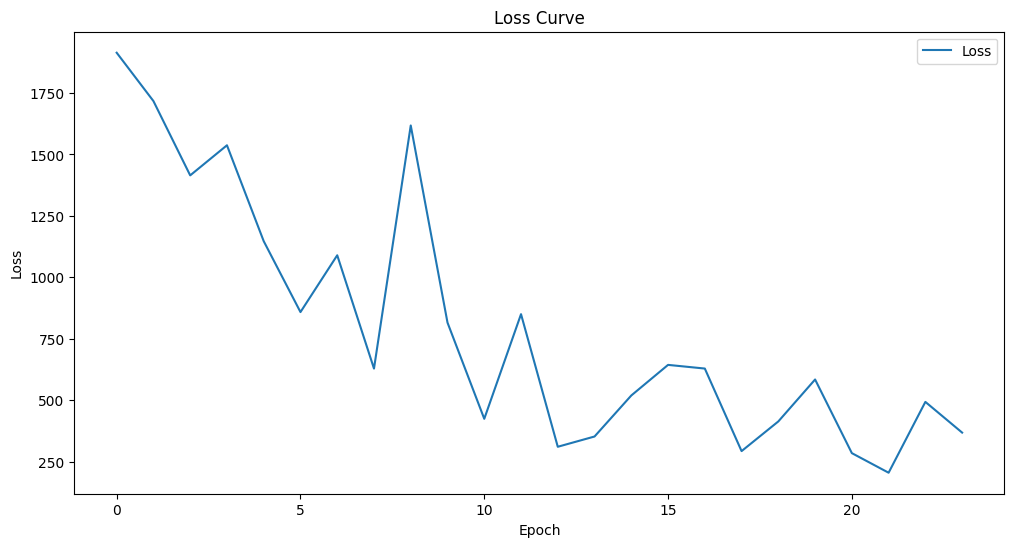

Epoch [24/80], Loss: 368.26251220703125


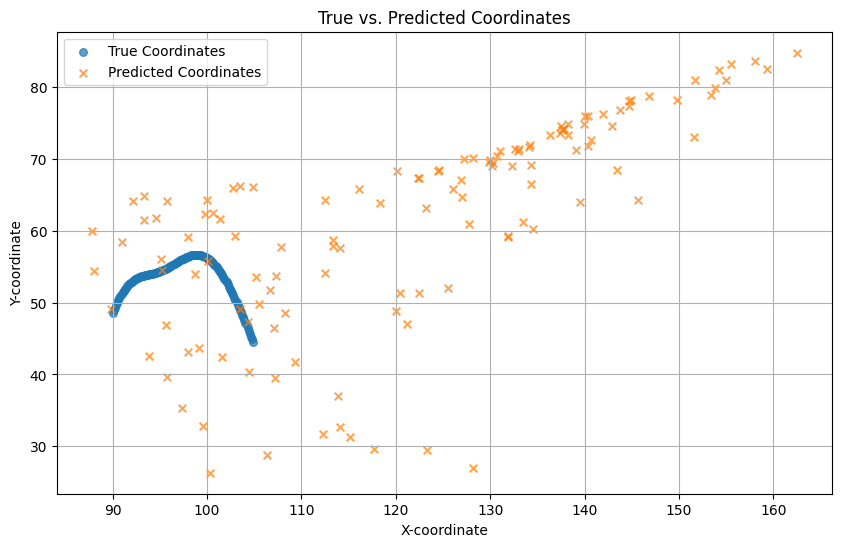

Test Loss: 582.221923828125


In [7]:
# 定义更深的神经网络模型
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import Config as cf
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from sklearn.model_selection import train_test_split
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch.optim.lr_scheduler import StepLR
import DnnModel
import Config as cf

# 数据预处理
# train_other_inputs = np.concatenate((train_w, train_doppler, train_position), axis=1)  # 将 相位差和多普勒 拼接
# test_other_inputs = np.concatenate((test_w, test_doppler, test_position), axis=1)  # 将 相位差和多普勒 拼接

# inputs_train, inputs_test, coords_train, coords_test = train_test_split(inputs, train_data_coords, test_size=0.1, random_state=42)

# 定义一个 PyTorch 数据集
class CoordDataset(Dataset):
    def __init__(self, inputs, coords):
        # 确保 inputs 和 coords 都是 torch.float32 类型
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.coords = torch.tensor(coords, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.coords[idx]
    
# 创建训练和测试数据集
train_dataset = CoordDataset(train_inputs, train_label)
test_dataset = CoordDataset(test_inputs, test_label)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=cf.train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=cf.test_batch_size, shuffle=False)

# 使用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnnModel.DNN().to(device)

# 损失函数和优化器s
optimizer = optim.Adam(model.parameters(), lr=cf.learning_rate)
criterion = nn.MSELoss()

# 训练模型
loss_values = []  # 存储损失值以供绘图

for epoch in range(cf.epoch):
    for inputs, coords in train_loader:
        inputs, coords = inputs.to(device), coords.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())

    # 动态绘图
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(loss_values, label="Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # 打印损失信息
    print(f"Epoch [{epoch+1}/{cf.epoch}], Loss: {loss.item()}")

    # 测试模型
    model.eval()
    total_test_loss = 0
    predicted_coords = []
    true_coords = []
    with torch.no_grad():
        for inputs, coords in test_loader:
            inputs, coords = inputs.to(device), coords.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, coords)
            total_test_loss += test_loss.item()
            predicted_coords.append(outputs.cpu().numpy())
            true_coords.append(coords.cpu().numpy())

    # 合并所有批次的预测结果和真实值
    predicted_coords = np.concatenate(predicted_coords, axis=0)
    true_coords = np.concatenate(true_coords, axis=0)
    # 绘制散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(
        true_coords[:, 0],
        true_coords[:, 1],
        label="True Coordinates",
        marker="o",
        s=30,
        alpha=0.7,
    )
    plt.scatter(
        predicted_coords[:, 0],
        predicted_coords[:, 1],
        label="Predicted Coordinates",
        marker="x",
        s=30,
        alpha=0.7,
    )
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.title("True vs. Predicted Coordinates")
    plt.grid(True)
    plt.show()
    print(f"Test Loss: {total_test_loss / len(test_loader)}")
# print("Testing...")


In [ ]:
# # 测试模型
# model.eval()
# total_test_loss = 0
# predicted_coords = []
# true_coords = []
# with torch.no_grad():
#     for inputs, coords in test_loader:
#         inputs, coords = inputs.to(device), coords.to(device)
#         outputs = model(inputs)
#         test_loss = triangleConstraintLoss(outputs, coords, vertex1, vertex2, vertex3)
#         total_test_loss += test_loss.item()
#         predicted_coords.append(outputs.cpu().numpy())
#         true_coords.append(coords.cpu().numpy())

# # 合并所有批次的预测结果和真实值
# predicted_coords = np.concatenate(predicted_coords, axis=0)
# true_coords = np.concatenate(true_coords, axis=0)
# # 绘制散点图
# plt.figure(figsize=(10, 6))
# plt.scatter(true_coords[:, 0], true_coords[:, 1], label='True Coordinates', marker='o', s=30, alpha=0.7)
# plt.scatter(predicted_coords[:, 0], predicted_coords[:, 1], label='Predicted Coordinates', marker='x', s=30, alpha=0.7)
# plt.xlabel('X-coordinate')
# plt.ylabel('Y-coordinate')
# plt.legend()
# plt.title('True vs. Predicted Coordinates')
# plt.grid(True)
# plt.show()
# print(f'Test Loss: {total_test_loss / len(test_loader)}')

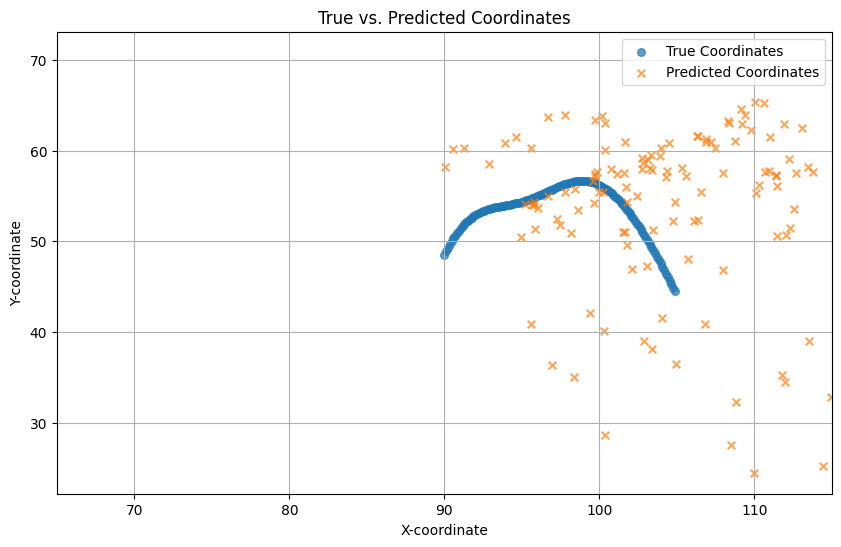

Test Loss: 79.3199691772461


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(true_coords[:, 0], true_coords[:, 1], label='True Coordinates', marker='o', s=30, alpha=0.7)
plt.scatter(predicted_coords[:, 0], predicted_coords[:, 1], label='Predicted Coordinates', marker='x', s=30, alpha=0.7)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('True vs. Predicted Coordinates')
plt.grid(True)
plt.xlim(65,115)
plt.show()
print(f'Test Loss: {total_test_loss / len(test_loader)}')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


# 数据预处理
inputs = np.concatenate((train_w, v), axis=1)  # 将 w 和 v 拼接
inputs_train, inputs_test, coords_train, coords_test = train_test_split(inputs, train_label, test_size=0.5, random_state=42)

# inputs_test = inputs_t
# coords_test = result_test

# 定义一个 PyTorch 数据集
# 定义一个 PyTorch 数据集
class CoordDataset(Dataset):
    def __init__(self, inputs, coords):
        # 确保 inputs 和 coords 都是 torch.float32 类型
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.coords = torch.tensor(coords, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.coords[idx]
# 创建训练和测试数据集
train_dataset = CoordDataset(inputs_train, coords_train)
test_dataset = CoordDataset(inputs_test, coords_test)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 定义更深的神经网络模型
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 512)  # 新增层
        self.fc5 = nn.Linear(512, 512)  # 新增层
        self.fc6 = nn.Linear(512, 256)
        self.fc7 = nn.Linear(256, 128)
        self.fc8 = nn.Linear(128, 64)
        self.fc9 = nn.Linear(64, 32)
        self.fc10 = nn.Linear(32, 4)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))  # 新增层
        x = self.relu(self.fc5(x))  # 新增层
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)
        return x

# 使用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN().to(device)

#考虑约束关系
#两个接收机的圆相交点
#计算A点和B点的距离差






[
    
]
#分段训练 10000个点 收敛 学习率降低 步长变短 
#增加数据点


# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# 训练模型
cf.epoch = 1500
for epoch in range(cf.epoch):
    for inputs, coords in train_loader:
        inputs, coords = inputs.to(device), coords.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{cf.epoch}], Loss: {loss.item()}')

# 测试模型
model.eval()
total_test_loss = 0
predicted_coords = []
true_coords = []
with torch.no_grad():
    for inputs, coords in test_loader:
        inputs, coords = inputs.to(device), coords.to(device)
        outputs = model(inputs)
        test_loss = criterion(outputs, coords)
        total_test_loss += test_loss.item()
        predicted_coords.append(outputs.cpu().numpy())
        true_coords.append(coords.cpu().numpy())

# 合并所有批次的预测结果和真实值
predicted_coords = np.concatenate(predicted_coords, axis=0)
true_coords = np.concatenate(true_coords, axis=0)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(true_coords[:, 0], true_coords[:, 1], label='True Coordinates', marker='o', s=30, alpha=0.7)
plt.scatter(predicted_coords[:, 0], predicted_coords[:, 1], label='Predicted Coordinates', marker='x', s=30, alpha=0.7)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('True vs. Predicted Coordinates')
plt.grid(True)
plt.show()
print(f'Test Loss: {total_test_loss / len(test_loader)}')

NameError: name 'v' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(true_coords[:1497, 0], true_coords[:1497, 1], label='True Coordinates', marker='o', s=30, alpha=0.7)
plt.scatter(predicted_coords[:1497, 0], predicted_coords[:1497, 1], label='Predicted Coordinates', marker='x', s=30, alpha=0.7)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('True vs. Predicted Coordinates')
plt.grid(True)
plt.show()
print(f'Test Loss: {total_test_loss / len(test_loader)}')

In [ ]:
d1 = 0
d2 = 0
for i in range(len(true_coords)-1):
    x = true_coords[i, 0]
    y = true_coords[i, 1]
    x1 = predicted_coords[i, 0]
    y1 = predicted_coords[i, 1]
    d11 = calculate_distance(x,y,vertex1[0],vertex1[1])
    d12 = calculate_distance(x1,y1,vertex1[0],vertex1[1])
    d21 = calculate_distance(x,y,vertex2[0],vertex2[1])
    d22 = calculate_distance(x1,y1,vertex2[0],vertex2[1])
    d31 = calculate_distance(x,y,vertex3[0],vertex3[1])
    d32 = calculate_distance(x1,y1,vertex3[0],vertex3[1])
    dd12 = np.abs(d11+d21-d12-d22)
    dd13 = np.abs(d11+d31-d12-d32)
    d1 = d1+dd12
    d2 = d2+dd13

In [ ]:
d2/len(true_coords)